In [1]:
import numpy as np
import pickle
import tensorflow as tf

from model import PMF

In [6]:
print('===== TRAINING PMF =====')
## initializing hyperparameters
batch_size = 64
epoches = 1000
seed = 1
weight_decay = 0.1
emb_dim = 100
ratio = 0.8
test_ratio = 0.5
lr = 1e-3
momentum = 0.9

## loading dataset
users = pickle.load(open('dataset_RL/user_id_to_num.pkl', 'rb'))
items = pickle.load(open('dataset_RL/item_id_to_num.pkl', 'rb'))
# data = np.load('dataset_RL/data_RL_25000.npy')
train_data = np.load('dataset_RL/train_data_RL_75000.npy')
test_data = np.load('dataset_RL/test_data_RL_75000.npy')

print("===== Dataset has been loaded =====")

## As the paper implemented, normalizing the rating
## that will act as reward
train_data[:, 2] = 0.5 * (train_data[:, 2] - 3)
test_data[:, 2] = 0.5 * (test_data[:, 2] - 3)

## Shuffle data
np.random.shuffle(train_data)
np.random.shuffle(test_data)

## Splitting data data
# train_data = data[:int(ratio * data.shape[0])]
# vali_data = data[int(ratio * data.shape[0]):int((ratio + (1 - ratio) / 2) * data.shape[0])]
# test_data = data[int((ratio + ( 1 - ratio ) / 2) * data.shape[0]):]
vali_data = test_data[:int(test_ratio * test_data.shape[0])]
test_data = test_data[int(test_ratio * test_data.shape[0]):]

 
## Extract number of users and items
NUM_USERS = len(users)
NUM_ITEMS = len(items)

train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data).batch(batch_size)
print("===== Preprocess the data has been finished =====")

model = PMF(NUM_USERS, NUM_ITEMS, emb_dim)
model(1, 1)

print("===== Model Instantiated =====")
model.summary()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

def train(train_dataset, len_dataset):
    
    epoch_loss = 0.0
    
    for step, elem in enumerate(train_dataset):
        row = elem[:, 0] ## users as a row
        col = elem[:, 1] ## items as a column
        val = elem[:, 2] ## normalized ratings as value
        
        with tf.GradientTape() as tape:
            
            ## Perlu diperiksa kembali
            row = tf.Variable(row, trainable=False)
            col = tf.Variable(col, trainable=False)
            val = tf.Variable(val, trainable=False)
            
            ## run the forward pass
            logits = model(row, col, training=True)
            
            ## compute the loss value
            loss_value = loss_fn(val, logits)
            
        ## using gradien tape to automatically retrieves
        ## the gradients of the trainable variables with respect to loss
        grads = tape.gradient(loss_value, model.trainable_weights)
        
        ## run one step of gradient descent by updating
        ## the value of variable loss
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        epoch_loss += loss_value
        
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
    
    return float(loss_value)
    
print("===== Training Model =====")
## this list is used for visualization
train_loss_list = []
train_rmse_list = []
vali_rmse_list = []
len_train_data = len(train_data)

last_vali_rmse = None

for epoch in range(epoches):
    ## train epoch losses
    print("\nStart of epoch %d" % (epoch,))
    
    train_epoch_loss = train(train_dataset, len_train_data)
    
    ## test 
    train_loss_list.append(train_epoch_loss)
    
    ## creating index for predicting
    vali_row = tf.Variable(tf.convert_to_tensor(vali_data[:, 0]), trainable=False)
    vali_col = tf.Variable(tf.convert_to_tensor(vali_data[:, 1]), trainable=False)
    
    ## predicting the value
    vali_preds = model(vali_row, vali_col, training=False)
    
    ## calculating rmse
    train_rmse = np.sqrt(train_epoch_loss)
    vali_rmse = np.sqrt(np.square(np.subtract(vali_data[:, 2], vali_preds)).mean())
    
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)
    
    print('Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}'.format(epoch+1, train_rmse, vali_rmse))
    
    if last_vali_rmse and last_vali_rmse < vali_rmse:
        break
    else:
        last_vali_rmse = vali_rmse

print("===== Testing Model =====")
test_row = tf.Variable(tf.convert_to_tensor(test_data[:, 0]), trainable=False)
test_col = tf.Variable(tf.convert_to_tensor(test_data[:, 1]), trainable=False)

preds = model(test_row, test_col, training=False)

test_rmse = np.sqrt(np.square(np.subtract(test_data[:, 2], preds)).mean())
print('Test rmse: {:f}'.format(test_rmse))

===== TRAINING PMF =====
===== Dataset has been loaded =====
===== Preprocess the data has been finished =====
===== Model Instantiated =====
Model: "pmf_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     multiple                  82200     
                                                                 
 embedding_5 (Embedding)     multiple                  14200     
                                                                 
 embedding_6 (Embedding)     multiple                  822       
                                                                 
 embedding_7 (Embedding)     multiple                  142       
                                                                 
Total params: 97,364
Trainable params: 97,364
Non-trainable params: 0
_________________________________________________________________
===== Training Model =====

Start of epoch 0
Tr

Training loss (for one batch) at step 400: 0.4114
Training loss (for one batch) at step 600: 0.4440
Training epoch: 26, training rmse: 0.628329, vali rmse:0.664926

Start of epoch 26
Training loss (for one batch) at step 0: 0.4190
Training loss (for one batch) at step 200: 0.5168
Training loss (for one batch) at step 400: 0.4094
Training loss (for one batch) at step 600: 0.4392
Training epoch: 27, training rmse: 0.622626, vali rmse:0.660330

Start of epoch 27
Training loss (for one batch) at step 0: 0.4148
Training loss (for one batch) at step 200: 0.5091
Training loss (for one batch) at step 400: 0.4074
Training loss (for one batch) at step 600: 0.4346
Training epoch: 28, training rmse: 0.617158, vali rmse:0.655960

Start of epoch 28
Training loss (for one batch) at step 0: 0.4108
Training loss (for one batch) at step 200: 0.5018
Training loss (for one batch) at step 400: 0.4054
Training loss (for one batch) at step 600: 0.4300
Training epoch: 29, training rmse: 0.611909, vali rmse:0.

Training loss (for one batch) at step 600: 0.3446
Training epoch: 55, training rmse: 0.522368, vali rmse:0.584268

Start of epoch 55
Training loss (for one batch) at step 0: 0.3364
Training loss (for one batch) at step 200: 0.3852
Training loss (for one batch) at step 400: 0.3555
Training loss (for one batch) at step 600: 0.3422
Training epoch: 56, training rmse: 0.520117, vali rmse:0.582640

Start of epoch 56
Training loss (for one batch) at step 0: 0.3346
Training loss (for one batch) at step 200: 0.3826
Training loss (for one batch) at step 400: 0.3540
Training loss (for one batch) at step 600: 0.3400
Training epoch: 57, training rmse: 0.517928, vali rmse:0.581060

Start of epoch 57
Training loss (for one batch) at step 0: 0.3328
Training loss (for one batch) at step 200: 0.3800
Training loss (for one batch) at step 400: 0.3526
Training loss (for one batch) at step 600: 0.3378
Training epoch: 58, training rmse: 0.515798, vali rmse:0.579527

Start of epoch 58
Training loss (for one b

Training loss (for one batch) at step 200: 0.3335
Training loss (for one batch) at step 400: 0.3242
Training loss (for one batch) at step 600: 0.2956
Training epoch: 85, training rmse: 0.475472, vali rmse:0.551483

Start of epoch 85
Training loss (for one batch) at step 0: 0.2985
Training loss (for one batch) at step 200: 0.3323
Training loss (for one batch) at step 400: 0.3234
Training loss (for one batch) at step 600: 0.2945
Training epoch: 86, training rmse: 0.474460, vali rmse:0.550817

Start of epoch 86
Training loss (for one batch) at step 0: 0.2977
Training loss (for one batch) at step 200: 0.3312
Training loss (for one batch) at step 400: 0.3227
Training loss (for one batch) at step 600: 0.2935
Training epoch: 87, training rmse: 0.473473, vali rmse:0.550171

Start of epoch 87
Training loss (for one batch) at step 0: 0.2969
Training loss (for one batch) at step 200: 0.3301
Training loss (for one batch) at step 400: 0.3220
Training loss (for one batch) at step 600: 0.2924
Trainin

Training loss (for one batch) at step 400: 0.3089
Training loss (for one batch) at step 600: 0.2730
Training epoch: 114, training rmse: 0.454360, vali rmse:0.538451

Start of epoch 114
Training loss (for one batch) at step 0: 0.2821
Training loss (for one batch) at step 200: 0.3095
Training loss (for one batch) at step 400: 0.3085
Training loss (for one batch) at step 600: 0.2725
Training epoch: 115, training rmse: 0.453866, vali rmse:0.538177

Start of epoch 115
Training loss (for one batch) at step 0: 0.2817
Training loss (for one batch) at step 200: 0.3089
Training loss (for one batch) at step 400: 0.3082
Training loss (for one batch) at step 600: 0.2719
Training epoch: 116, training rmse: 0.453382, vali rmse:0.537912

Start of epoch 116
Training loss (for one batch) at step 0: 0.2813
Training loss (for one batch) at step 200: 0.3084
Training loss (for one batch) at step 400: 0.3079
Training loss (for one batch) at step 600: 0.2714
Training epoch: 117, training rmse: 0.452910, vali 

Training loss (for one batch) at step 400: 0.3012
Training loss (for one batch) at step 600: 0.2614
Training epoch: 143, training rmse: 0.443669, vali rmse:0.533164

Start of epoch 143
Training loss (for one batch) at step 0: 0.2742
Training loss (for one batch) at step 200: 0.2983
Training loss (for one batch) at step 400: 0.3010
Training loss (for one batch) at step 600: 0.2611
Training epoch: 144, training rmse: 0.443404, vali rmse:0.533055

Start of epoch 144
Training loss (for one batch) at step 0: 0.2740
Training loss (for one batch) at step 200: 0.2981
Training loss (for one batch) at step 400: 0.3008
Training loss (for one batch) at step 600: 0.2608
Training epoch: 145, training rmse: 0.443143, vali rmse:0.532950

Start of epoch 145
Training loss (for one batch) at step 0: 0.2738
Training loss (for one batch) at step 200: 0.2978
Training loss (for one batch) at step 400: 0.3006
Training loss (for one batch) at step 600: 0.2605
Training epoch: 146, training rmse: 0.442888, vali 

Training loss (for one batch) at step 400: 0.2968
Training loss (for one batch) at step 600: 0.2547
Training epoch: 172, training rmse: 0.437573, vali rmse:0.531108

Start of epoch 172
Training loss (for one batch) at step 0: 0.2698
Training loss (for one batch) at step 200: 0.2924
Training loss (for one batch) at step 400: 0.2967
Training loss (for one batch) at step 600: 0.2546
Training epoch: 173, training rmse: 0.437407, vali rmse:0.531067

Start of epoch 173
Training loss (for one batch) at step 0: 0.2697
Training loss (for one batch) at step 200: 0.2923
Training loss (for one batch) at step 400: 0.2965
Training loss (for one batch) at step 600: 0.2544
Training epoch: 174, training rmse: 0.437244, vali rmse:0.531028

Start of epoch 174
Training loss (for one batch) at step 0: 0.2696
Training loss (for one batch) at step 200: 0.2921
Training loss (for one batch) at step 400: 0.2964
Training loss (for one batch) at step 600: 0.2542
Training epoch: 175, training rmse: 0.437083, vali 

Training loss (for one batch) at step 400: 0.2938
Training loss (for one batch) at step 600: 0.2505
Training epoch: 201, training rmse: 0.433438, vali rmse:0.530365

Start of epoch 201
Training loss (for one batch) at step 0: 0.2670
Training loss (for one batch) at step 200: 0.2889
Training loss (for one batch) at step 400: 0.2937
Training loss (for one batch) at step 600: 0.2503
Training epoch: 202, training rmse: 0.433313, vali rmse:0.530351

Start of epoch 202
Training loss (for one batch) at step 0: 0.2669
Training loss (for one batch) at step 200: 0.2888
Training loss (for one batch) at step 400: 0.2936
Training loss (for one batch) at step 600: 0.2502
Training epoch: 203, training rmse: 0.433189, vali rmse:0.530338

Start of epoch 203
Training loss (for one batch) at step 0: 0.2668
Training loss (for one batch) at step 200: 0.2887
Training loss (for one batch) at step 400: 0.2935
Training loss (for one batch) at step 600: 0.2501
Training epoch: 204, training rmse: 0.433066, vali 

Training loss (for one batch) at step 400: 0.2912
Training loss (for one batch) at step 600: 0.2472
Training epoch: 230, training rmse: 0.430040, vali rmse:0.530135

Start of epoch 230
Training loss (for one batch) at step 0: 0.2646
Training loss (for one batch) at step 200: 0.2862
Training loss (for one batch) at step 400: 0.2912
Training loss (for one batch) at step 600: 0.2471
Training epoch: 231, training rmse: 0.429928, vali rmse:0.530132

Start of epoch 231
Training loss (for one batch) at step 0: 0.2645
Training loss (for one batch) at step 200: 0.2862
Training loss (for one batch) at step 400: 0.2911
Training loss (for one batch) at step 600: 0.2470
Training epoch: 232, training rmse: 0.429815, vali rmse:0.530129

Start of epoch 232
Training loss (for one batch) at step 0: 0.2645
Training loss (for one batch) at step 200: 0.2861
Training loss (for one batch) at step 400: 0.2910
Training loss (for one batch) at step 600: 0.2469
Training epoch: 233, training rmse: 0.429703, vali 

In [20]:
print("===== Testing Model =====")
test_row = tf.convert_to_tensor(test_data[:, 0])
test_col = tf.convert_to_tensor(test_data[:, 1])

preds = model(test_row, test_col, training=False)

test_rmse = np.sqrt(np.square(np.subtract(test_data[:, 2], preds)).mean())
print('Test rmse: {:f}'.format(test_rmse))

===== Testing Model =====
Test rmse: 0.505202


In [8]:
model.save_weights('trained/pmf_weights/pmf_oversampling_undersampling')

In [5]:
model.load_weights('trained/pmf_weights/pmf_150')

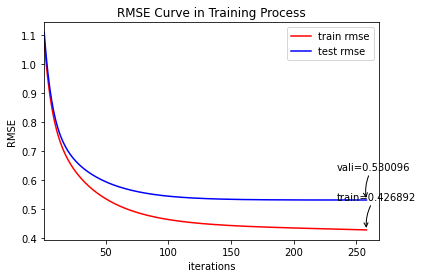

In [7]:
import matplotlib.pyplot as plt

# Create plots
plt.figure(1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color='r', label='train rmse')
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color='b', label='test rmse')
plt.legend()
plt.annotate(r'train=%f' % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.annotate(r'vali=%f' % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.title('RMSE Curve in Training Process')
plt.show()